In [3]:
import os
import sys

import matplotlib.pyplot as plt
from hydra import compose, initialize

MODULES_PATH = os.path.dirname(os.path.dirname(os.getcwd()))

if MODULES_PATH not in sys.path:
    sys.path.append(MODULES_PATH)
    
import math
import torch
import torch.nn as nn

import pytorch_lightning as lightning
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint 

import dev.utils as utils
import dev.plot_utils as plot_utils

from dev.ssm_modules.dynamics import DenseGaussianDynamics
from dev.ssm_modules.likelihoods import GaussianLikelihood
from dev.smoothers.lightning_trainers import LightningNonlinearSSM
from dev.ssm_modules.dynamics import DenseGaussianInitialCondition
from dev.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from dev.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

In [4]:
torch.cuda.empty_cache()

In [5]:
"""config"""

initialize(version_base=None, config_path="", job_name="lds")
cfg = compose(config_name="config")

lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1234


In [6]:
"""generate data -- 2d oscillator with decay"""

n_trials = 500
n_neurons = 100
n_time_bins = 250

mean_fn = utils.VdpDynamicsModel()

C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device).requires_grad_(False)
Q_diag = 1e-2 * torch.ones(cfg.n_latents, device=cfg.device)
Q_0_diag = torch.ones(cfg.n_latents, device=cfg.device)
R_diag = 1e-1 * torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()

In [7]:
y_train, z_train = y[:n_trials//2], z[:n_trials//2]
y_valid, z_valid = y[n_trials//2:], z[n_trials//2:]

y_train_dataset = torch.utils.data.TensorDataset(y_train,)
y_valid_dataset = torch.utils.data.TensorDataset(y_valid,)

train_dataloader = torch.utils.data.DataLoader(
    y_train_dataset,
    batch_size=cfg.batch_sz,
    shuffle=True
)
valid_dataloader = torch.utils.data.DataLoader(
    y_valid_dataset,
    batch_size=cfg.batch_sz,
    shuffle=True
)

In [8]:
"""likelihood pdf"""

likelihood_pdf = GaussianLikelihood(C, n_neurons, R_diag, device=cfg.device)

In [9]:
"""dynamics module"""

dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

In [10]:
"""initial condition"""
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

In [11]:
"""local/backward encoder"""

backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)

local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents, rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)

In [ ]:
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

In [12]:
"""sequence vae"""

ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

In [13]:
"""lightning"""

seq_vae = LightningNonlinearSSM.load_from_checkpoint(torch.load(f'ckpts/best_model_path.pt'), ssm=ssm, cfg=cfg)

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_52402/2993901760.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_52402/2993901760.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


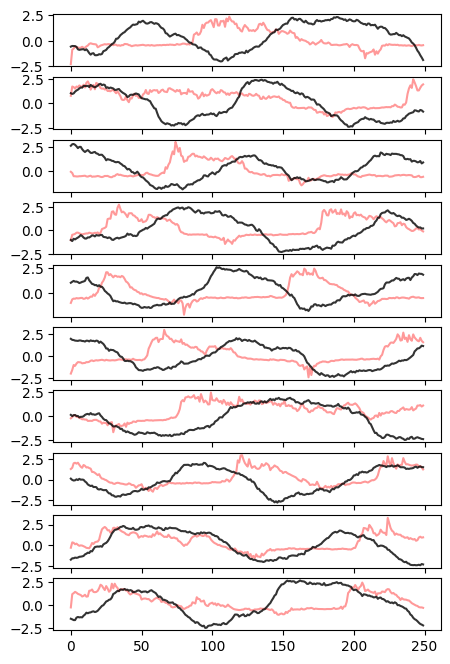

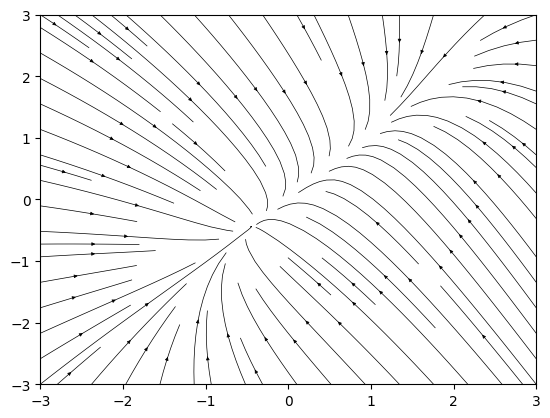

In [14]:
loss, z, stats = seq_vae.ssm(y_valid, cfg.n_samples)

n_ex = 10

fig, axs = plt.subplots(n_ex, 1, figsize=(5, 8))

[axs[i].plot(stats['m_f'][i, :, 0].detach().numpy(), color='red', alpha=0.4) for i in range(n_ex)]
[axs[i].plot(z_valid[i, :, 0].detach().numpy(), color='black', alpha=0.8) for i in range(n_ex)]

fig.show()

fig, axs = plt.subplots()
plot_utils.plot_two_d_vector_field(seq_vae.ssm.dynamics_mod.mean_fn, axs)
fig.show()

In [15]:
loss

tensor(194555.3750, grad_fn=<MeanBackward0>)

In [16]:
z.shape

torch.Size([5, 250, 250, 2])

In [17]:
stats.keys()

dict_keys(['kl', 'm_s', 'm_f', 'm_p', 'Psi_f', 'Psi_p'])

In [52]:
y_valid.shape

torch.Size([250, 250, 100])